In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
plt.style.use('fivethirtyeight')

In [3]:
#读取数据 
data=pd.read_excel('data.xlsx') 
data=data.iloc[:,:]
choose='BASPL'#选取这一列
data.tail()

,年,月,ASPL,BME,BASPL,BLD,BLW,BJ,JN,LBL,SN,TJ,ST,SX,XMD,YXX
55,2019,8,3.763248e+06,62854.619304,8.599843e+07,1.650015e+08,3.481067e+08,1.060927e+06,2.359482e+06,13219.096853,6.456187e+05,1.758874e+08,2.961155e+07,1.949292e+07,56728.894684,107392.856432
56,2019,9,4.294952e+06,51559.590738,1.052790e+08,1.811433e+08,4.621942e+08,1.135383e+06,2.416740e+06,224849.311140,1.233509e+06,2.395380e+08,3.489288e+07,2.116995e+07,26868.589363,227671.344996
57,2019,10,2.835714e+06,31933.698695,8.023482e+07,1.674704e+08,3.022591e+08,1.023727e+06,2.074879e+06,32356.283055,4.381713e+05,1.561968e+08,2.178650e+07,1.655320e+07,32469.492085,134291.930366
58,2019,11,3.188248e+06,42248.757526,9.053573e+07,1.624495e+08,2.918764e+08,1.297557e+06,2.163609e+06,136809.701451,8.436577e+05,1.604672e+08,2.843713e+07,1.799922e+07,30197.836641,201416.711500
59,2019,12,4.437618e+06,67250.974962,1.034565e+08,1.545455e+08,2.355498e+08,1.336709e+06,2.369512e+06,246160.303870,6.326834e+05,1.424411e+08,2.360613e+07,1.968310e+07,20921.125742,157548.075168


Text(0.5, 1.0, 'BASPL')

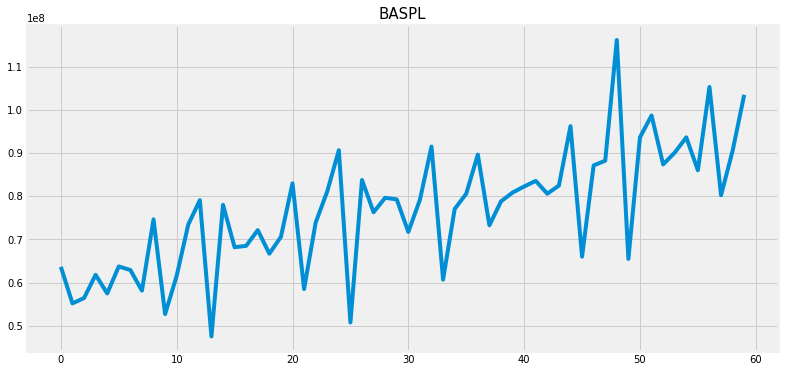

In [4]:
#展示一下看看
data=data[choose]
plt.figure(figsize=(12,6))
plt.plot(data)
#plt.grid()
plt.title(choose,fontsize='15') #添加标题

In [5]:
#构造针对机器学习模型的数据集
window=12#时间窗为12
data=data.values 
dataset=data
for i in range(window):
    zero=np.zeros(i+1)
    temp=np.append(data[i+1:],zero)
    dataset=np.row_stack((dataset,temp))
dataset=pd.DataFrame(dataset).T
dataset=dataset.iloc[:-window]
dataset=dataset/10000000#进行伪归一化
dataset.tail()#构造好的数据集如下

,0,1,2,3,4,5,6,7,8,9,10,11,12
43,8.246982,9.620531,6.602126,8.713054,8.821096,11.614596,6.550721,9.362264,9.868245,8.736202,9.008205,9.361410,8.599843
44,9.620531,6.602126,8.713054,8.821096,11.614596,6.550721,9.362264,9.868245,8.736202,9.008205,9.361410,8.599843,10.527895
45,6.602126,8.713054,8.821096,11.614596,6.550721,9.362264,9.868245,8.736202,9.008205,9.361410,8.599843,10.527895,8.023482
46,8.713054,8.821096,11.614596,6.550721,9.362264,9.868245,8.736202,9.008205,9.361410,8.599843,10.527895,8.023482,9.053573
47,8.821096,11.614596,6.550721,9.362264,9.868245,8.736202,9.008205,9.361410,8.599843,10.527895,8.023482,9.053573,10.345651


In [6]:
#划分特征与标签
x=dataset.iloc[:,:-1]
y=dataset.iloc[:,-1]
print(x.shape)
print(y.shape)

(48, 12)
(48,)


In [7]:
#构造训练集测试集
cut=6#取最后cut天为测试集
X_train, X_test=x.iloc[:-cut],x.iloc[-cut:]#列表的切片操作
y_train, y_test=y.iloc[:-cut],y.iloc[-cut:]
X_train,X_test,y_train,y_test=X_train.values,X_test.values,y_train.values,y_test.values
print(X_train.size)#通过输出训练集测试集的大小来判断数据格式正确。
print(X_test.size)
print(y_train.size)
print(y_test.size)

504
72
42
6


In [8]:
#以下函数均为对模型进行检验所用到的 精简代码的作用
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100
def up_down_accuracy(y_true, y_pred):
    y_var_test=y_true[1:]-y_true[:len(y_true)-1]#实际涨跌
    y_var_predict=y_pred[1:]-y_pred[:len(y_pred)-1]#原始涨跌
    txt=np.zeros(len(y_var_test))
    for i in range(len(y_var_test-1)):#计算数量
        txt[i]=np.sign(y_var_test[i])==np.sign(y_var_predict[i])
    result=sum(txt)/len(txt)
    return result
def output():
    #在训练集上的拟合结果
    y_train_predict=model.predict(X_train)[:,0]
    #展示在训练集上的表现 
    draw=pd.concat([pd.DataFrame(y_train),pd.DataFrame(y_train_predict)],axis=1)
    draw.iloc[:,0].plot(figsize=(12,6))
    draw.iloc[:,1].plot(figsize=(12,6))
    plt.legend(('real', 'predict'),fontsize='15')
    plt.title("Train Data",fontsize='30') #添加标题
    plt.show()
    #在测试集上的预测
    y_test_predict=model.predict(X_test)[:,0]
    #展示在测试集上的表现 
    draw=pd.concat([pd.DataFrame(y_test),pd.DataFrame(y_test_predict)],axis=1);
    draw.iloc[:,0].plot(figsize=(12,6))
    draw.iloc[:,1].plot(figsize=(12,6))
    plt.legend(('real', 'predict'),loc='upper right',fontsize='15')
    plt.title("Test Data",fontsize='30') #添加标题
    plt.show()
    #输出结果
    print('训练集上的MAE/MSE/MAPE/涨跌准确率')
    print(mean_absolute_error(y_train_predict, y_train))
    print(mean_squared_error(y_train_predict, y_train) )
    print(mape(y_train_predict, y_train) )
    print(up_down_accuracy(y_train_predict,y_train))
    print('测试集上的MAE/MSE/MAPE/涨跌准确率')
    print(mean_absolute_error(y_test_predict, y_test))
    print(mean_squared_error(y_test_predict, y_test) )
    print(mape(y_test_predict,  y_test) )
    print(up_down_accuracy(y_test_predict,y_test))

In [9]:
#建立bp模型 展示
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import Adam
input_size=len(x.iloc[1,:])
model = Sequential()  #层次模型
model.add(Dense(16,input_dim=input_size,init='uniform')) #输入层，Dense表示BP层
model.add(Activation('tanh'))  #添加激活函数
model.add(Dense(1))   #输出层
model.compile(loss='mean_squared_error', optimizer='Adam') #编译模型
model.summary()

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                208       
_________________________________________________________________
activation_1 (Activation)    (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 225
Trainable params: 225
Non-trainable params: 0
_________________________________________________________________


E:\anoconda\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(16, input_dim=12, kernel_initializer="uniform")`
  import sys


In [10]:
#bp神经网络训练及结果
model.fit(X_train, y_train, nb_epoch = 1000, batch_size = 32) #训练模型nb_epoch=50次

Instructions for updating:
Use tf.cast instead.


E:\anoconda\lib\site-packages\ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Epoch 1/1000
42/42 [==============================] - 0s 3ms/step - loss: 52.1029
Epoch 2/1000
42/42 [==============================] - 0s 95us/step - loss: 42.4245
Epoch 3/1000
42/42 [==============================] - 0s 95us/step - loss: 34.4429
Epoch 4/1000
42/42 [==============================] - 0s 142us/step - loss: 28.2328
Epoch 5/1000
42/42 [==============================] - 0s 95us/step - loss: 23.1369
Epoch 6/1000
42/42 [==============================] - 0s 166us/step - loss: 19.3270
Epoch 7/1000
42/42 [==============================] - 0s 95us/step - loss: 16.5442
Epoch 8/1000
42/42 [==============================] - 0s 166us/step - loss: 14.5164
Epoch 9/1000
42/42 [==============================] - 0s 95us/step - loss: 13.0121
Epoch 10/1000
42/42 [==============================] - 0s 119us/step - loss: 11.8959
Epoch 11/1000
42/42 [==============================] - 0s 95us/step - loss: 11.0211
Epoch 12/1000
42/42 [==============================] - 0s 143us/step - loss: 10.36

42/42 [==============================] - 0s 166us/step - loss: 1.9584
Epoch 99/1000
42/42 [==============================] - 0s 119us/step - loss: 1.9412
Epoch 100/1000
42/42 [==============================] - 0s 119us/step - loss: 1.9233
Epoch 101/1000
42/42 [==============================] - 0s 94us/step - loss: 1.9068
Epoch 102/1000
42/42 [==============================] - 0s 119us/step - loss: 1.8902
Epoch 103/1000
42/42 [==============================] - 0s 95us/step - loss: 1.8762
Epoch 104/1000
42/42 [==============================] - 0s 95us/step - loss: 1.8603
Epoch 105/1000
42/42 [==============================] - 0s 119us/step - loss: 1.8432
Epoch 106/1000
42/42 [==============================] - 0s 95us/step - loss: 1.8322
Epoch 107/1000
42/42 [==============================] - 0s 95us/step - loss: 1.8177
Epoch 108/1000
42/42 [==============================] - 0s 95us/step - loss: 1.8038
Epoch 109/1000
42/42 [==============================] - 0s 71us/step - loss: 1.7921
Epo

42/42 [==============================] - 0s 142us/step - loss: 1.5304
Epoch 195/1000
42/42 [==============================] - 0s 95us/step - loss: 1.5299
Epoch 196/1000
42/42 [==============================] - 0s 95us/step - loss: 1.5297
Epoch 197/1000
42/42 [==============================] - 0s 95us/step - loss: 1.5292
Epoch 198/1000
42/42 [==============================] - 0s 71us/step - loss: 1.5291
Epoch 199/1000
42/42 [==============================] - 0s 95us/step - loss: 1.5287
Epoch 200/1000
42/42 [==============================] - 0s 95us/step - loss: 1.5286
Epoch 201/1000
42/42 [==============================] - 0s 71us/step - loss: 1.5282
Epoch 202/1000
42/42 [==============================] - 0s 119us/step - loss: 1.5281
Epoch 203/1000
42/42 [==============================] - 0s 119us/step - loss: 1.5278
Epoch 204/1000
42/42 [==============================] - 0s 71us/step - loss: 1.5274
Epoch 205/1000
42/42 [==============================] - 0s 119us/step - loss: 1.5273
Epo

42/42 [==============================] - 0s 95us/step - loss: 1.4769
Epoch 291/1000
42/42 [==============================] - 0s 95us/step - loss: 1.4747
Epoch 292/1000
42/42 [==============================] - 0s 71us/step - loss: 1.4710
Epoch 293/1000
42/42 [==============================] - 0s 142us/step - loss: 1.4695
Epoch 294/1000
42/42 [==============================] - 0s 95us/step - loss: 1.4688
Epoch 295/1000
42/42 [==============================] - 0s 95us/step - loss: 1.4664
Epoch 296/1000
42/42 [==============================] - 0s 166us/step - loss: 1.4651
Epoch 297/1000
42/42 [==============================] - 0s 95us/step - loss: 1.4637
Epoch 298/1000
42/42 [==============================] - 0s 119us/step - loss: 1.4622
Epoch 299/1000
42/42 [==============================] - 0s 71us/step - loss: 1.4608
Epoch 300/1000
42/42 [==============================] - 0s 95us/step - loss: 1.4597
Epoch 301/1000
42/42 [==============================] - 0s 93us/step - loss: 1.4584
Epoc

42/42 [==============================] - 0s 95us/step - loss: 1.2896
Epoch 387/1000
42/42 [==============================] - 0s 95us/step - loss: 1.2866
Epoch 388/1000
42/42 [==============================] - 0s 71us/step - loss: 1.2837
Epoch 389/1000
42/42 [==============================] - 0s 71us/step - loss: 1.2806
Epoch 390/1000
42/42 [==============================] - 0s 95us/step - loss: 1.2779
Epoch 391/1000
42/42 [==============================] - 0s 119us/step - loss: 1.2752
Epoch 392/1000
42/42 [==============================] - 0s 119us/step - loss: 1.2716
Epoch 393/1000
42/42 [==============================] - 0s 71us/step - loss: 1.2695
Epoch 394/1000
42/42 [==============================] - 0s 143us/step - loss: 1.2647
Epoch 395/1000
42/42 [==============================] - 0s 95us/step - loss: 1.2625
Epoch 396/1000
42/42 [==============================] - 0s 71us/step - loss: 1.2607
Epoch 397/1000
42/42 [==============================] - 0s 142us/step - loss: 1.2579
Epo

42/42 [==============================] - 0s 119us/step - loss: 0.9893
Epoch 483/1000
42/42 [==============================] - 0s 95us/step - loss: 0.9852
Epoch 484/1000
42/42 [==============================] - 0s 119us/step - loss: 0.9802
Epoch 485/1000
42/42 [==============================] - 0s 95us/step - loss: 0.9801
Epoch 486/1000
42/42 [==============================] - 0s 95us/step - loss: 0.9748
Epoch 487/1000
42/42 [==============================] - 0s 119us/step - loss: 0.9726
Epoch 488/1000
42/42 [==============================] - 0s 119us/step - loss: 0.9692
Epoch 489/1000
42/42 [==============================] - 0s 95us/step - loss: 0.9696
Epoch 490/1000
42/42 [==============================] - 0s 95us/step - loss: 0.9619
Epoch 491/1000
42/42 [==============================] - 0s 95us/step - loss: 0.9581
Epoch 492/1000
42/42 [==============================] - 0s 95us/step - loss: 0.9576
Epoch 493/1000
42/42 [==============================] - 0s 119us/step - loss: 0.9631
Ep

42/42 [==============================] - 0s 166us/step - loss: 0.7003
Epoch 579/1000
42/42 [==============================] - 0s 95us/step - loss: 0.6964
Epoch 580/1000
42/42 [==============================] - 0s 119us/step - loss: 0.6920
Epoch 581/1000
42/42 [==============================] - 0s 71us/step - loss: 0.6895
Epoch 582/1000
42/42 [==============================] - 0s 95us/step - loss: 0.6910
Epoch 583/1000
42/42 [==============================] - 0s 119us/step - loss: 0.6938
Epoch 584/1000
42/42 [==============================] - 0s 166us/step - loss: 0.6879
Epoch 585/1000
42/42 [==============================] - 0s 143us/step - loss: 0.6897
Epoch 586/1000
42/42 [==============================] - 0s 71us/step - loss: 0.6814
Epoch 587/1000
42/42 [==============================] - 0s 95us/step - loss: 0.6761
Epoch 588/1000
42/42 [==============================] - 0s 119us/step - loss: 0.6765
Epoch 589/1000
42/42 [==============================] - 0s 143us/step - loss: 0.6772


42/42 [==============================] - 0s 119us/step - loss: 0.5304
Epoch 675/1000
42/42 [==============================] - 0s 190us/step - loss: 0.5272
Epoch 676/1000
42/42 [==============================] - 0s 142us/step - loss: 0.5335
Epoch 677/1000
42/42 [==============================] - 0s 166us/step - loss: 0.5395
Epoch 678/1000
42/42 [==============================] - 0s 119us/step - loss: 0.5298
Epoch 679/1000
42/42 [==============================] - 0s 143us/step - loss: 0.5213
Epoch 680/1000
42/42 [==============================] - 0s 119us/step - loss: 0.5270
Epoch 681/1000
42/42 [==============================] - 0s 142us/step - loss: 0.5432
Epoch 682/1000
42/42 [==============================] - 0s 95us/step - loss: 0.5566
Epoch 683/1000
42/42 [==============================] - 0s 119us/step - loss: 0.5379
Epoch 684/1000
42/42 [==============================] - 0s 95us/step - loss: 0.5234
Epoch 685/1000
42/42 [==============================] - 0s 95us/step - loss: 0.522

42/42 [==============================] - 0s 119us/step - loss: 0.4581
Epoch 771/1000
42/42 [==============================] - 0s 95us/step - loss: 0.4548
Epoch 772/1000
42/42 [==============================] - 0s 95us/step - loss: 0.4674
Epoch 773/1000
42/42 [==============================] - 0s 119us/step - loss: 0.4731
Epoch 774/1000
42/42 [==============================] - 0s 119us/step - loss: 0.4608
Epoch 775/1000
42/42 [==============================] - 0s 119us/step - loss: 0.4502
Epoch 776/1000
42/42 [==============================] - 0s 95us/step - loss: 0.4598
Epoch 777/1000
42/42 [==============================] - 0s 71us/step - loss: 0.4914
Epoch 778/1000
42/42 [==============================] - 0s 142us/step - loss: 0.4515
Epoch 779/1000
42/42 [==============================] - 0s 119us/step - loss: 0.4781
Epoch 780/1000
42/42 [==============================] - 0s 119us/step - loss: 0.4918
Epoch 781/1000
42/42 [==============================] - 0s 95us/step - loss: 0.4619


42/42 [==============================] - 0s 95us/step - loss: 0.4201
Epoch 868/1000
42/42 [==============================] - 0s 119us/step - loss: 0.4197
Epoch 869/1000
42/42 [==============================] - 0s 95us/step - loss: 0.4190
Epoch 870/1000
42/42 [==============================] - 0s 95us/step - loss: 0.4193
Epoch 871/1000
42/42 [==============================] - 0s 95us/step - loss: 0.4239
Epoch 872/1000
42/42 [==============================] - 0s 95us/step - loss: 0.4263
Epoch 873/1000
42/42 [==============================] - 0s 95us/step - loss: 0.4228
Epoch 874/1000
42/42 [==============================] - 0s 95us/step - loss: 0.4174
Epoch 875/1000
42/42 [==============================] - 0s 95us/step - loss: 0.4194
Epoch 876/1000
42/42 [==============================] - 0s 95us/step - loss: 0.4272
Epoch 877/1000
42/42 [==============================] - 0s 95us/step - loss: 0.4186
Epoch 878/1000
42/42 [==============================] - 0s 71us/step - loss: 0.4169
Epoch 

42/42 [==============================] - 0s 95us/step - loss: 0.3983
Epoch 964/1000
42/42 [==============================] - 0s 166us/step - loss: 0.3990
Epoch 965/1000
42/42 [==============================] - 0s 95us/step - loss: 0.4058
Epoch 966/1000
42/42 [==============================] - 0s 190us/step - loss: 0.4088
Epoch 967/1000
42/42 [==============================] - 0s 95us/step - loss: 0.4067
Epoch 968/1000
42/42 [==============================] - 0s 142us/step - loss: 0.3922
Epoch 969/1000
42/42 [==============================] - 0s 71us/step - loss: 0.4025
Epoch 970/1000
42/42 [==============================] - 0s 95us/step - loss: 0.4490
Epoch 971/1000
42/42 [==============================] - 0s 95us/step - loss: 0.4166
Epoch 972/1000
42/42 [==============================] - 0s 95us/step - loss: 0.4027
Epoch 973/1000
42/42 [==============================] - 0s 142us/step - loss: 0.4347
Epoch 974/1000
42/42 [==============================] - 0s 95us/step - loss: 0.4336
Epo

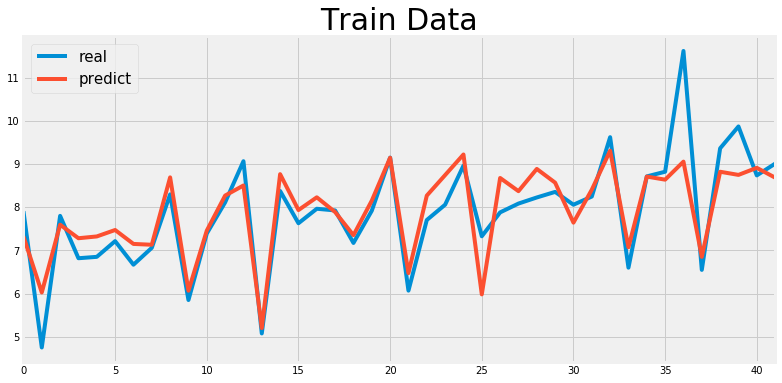

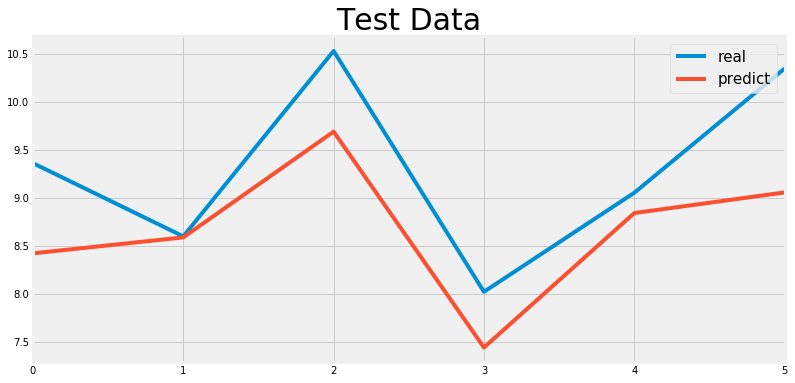

训练集上的MAE/MSE/MAPE/涨跌准确率
0.4407525385780512
0.3952973380021807
5.675421411112028
0.8292682926829268
测试集上的MAE/MSE/MAPE/涨跌准确率
0.6443326906488981
0.604049366773494
7.384506717893759
0.8


In [11]:
output()

In [12]:
#LSTM神经网络的数据集要稍微做一些修改
window=window
amount_of_features=1
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1], amount_of_features))
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1], amount_of_features))  
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(42, 12, 1)
(6, 12, 1)
(42,)
(6,)


In [13]:
#建立LSTM模型 训练
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
#建立训练模型过程
model = Sequential()#建立层次模型
model.add(LSTM(16, input_shape=(window, amount_of_features), return_sequences=False))#建立LSTM层
model.add(Dense(4,init='uniform',activation='relu'))   #建立全连接层     
model.add(Dense(1,init='uniform',activation='relu'))
model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 16)                1152      
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 68        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 5         
Total params: 1,225
Trainable params: 1,225
Non-trainable params: 0
_________________________________________________________________


E:\anoconda\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, activation="relu", kernel_initializer="uniform")`
  
E:\anoconda\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':


In [14]:
#神经网络训练及结果
model.fit(X_train, y_train, nb_epoch =1000, batch_size = 16) #训练模型nb_epoch次

E:\anoconda\lib\site-packages\ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Epoch 1/1000
42/42 [==============================] - 0s 11ms/step - loss: 63.6150 - accuracy: 0.0000e+00
Epoch 2/1000
42/42 [==============================] - 0s 380us/step - loss: 63.5402 - accuracy: 0.0000e+00
Epoch 3/1000
42/42 [==============================] - 0s 332us/step - loss: 63.4730 - accuracy: 0.0000e+00
Epoch 4/1000
42/42 [==============================] - 0s 333us/step - loss: 63.4057 - accuracy: 0.0000e+00
Epoch 5/1000
42/42 [==============================] - 0s 356us/step - loss: 63.3353 - accuracy: 0.0000e+00
Epoch 6/1000
42/42 [==============================] - 0s 380us/step - loss: 63.2608 - accuracy: 0.0000e+00
Epoch 7/1000
42/42 [==============================] - 0s 356us/step - loss: 63.1842 - accuracy: 0.0000e+00
Epoch 8/1000
42/42 [==============================] - 0s 356us/step - loss: 63.1025 - accuracy: 0.0000e+00
Epoch 9/1000
42/42 [==============================] - 0s 332us/step - loss: 63.0179 - accuracy: 0.0000e+00
Epoch 10/1000
42/42 [=================

Epoch 77/1000
42/42 [==============================] - 0s 332us/step - loss: 30.5584 - accuracy: 0.0000e+00
Epoch 78/1000
42/42 [==============================] - 0s 356us/step - loss: 29.9394 - accuracy: 0.0000e+00
Epoch 79/1000
42/42 [==============================] - 0s 332us/step - loss: 29.3242 - accuracy: 0.0000e+00
Epoch 80/1000
42/42 [==============================] - 0s 356us/step - loss: 28.7204 - accuracy: 0.0000e+00
Epoch 81/1000
42/42 [==============================] - 0s 332us/step - loss: 28.1214 - accuracy: 0.0000e+00
Epoch 82/1000
42/42 [==============================] - 0s 332us/step - loss: 27.5239 - accuracy: 0.0000e+00
Epoch 83/1000
42/42 [==============================] - 0s 356us/step - loss: 26.9217 - accuracy: 0.0000e+00
Epoch 84/1000
42/42 [==============================] - 0s 356us/step - loss: 26.3328 - accuracy: 0.0000e+00
Epoch 85/1000
42/42 [==============================] - 0s 356us/step - loss: 25.7357 - accuracy: 0.0000e+00
Epoch 86/1000
42/42 [=======

42/42 [==============================] - 0s 332us/step - loss: 3.3181 - accuracy: 0.0000e+00
Epoch 153/1000
42/42 [==============================] - 0s 309us/step - loss: 3.2295 - accuracy: 0.0000e+00
Epoch 154/1000
42/42 [==============================] - 0s 380us/step - loss: 3.1354 - accuracy: 0.0000e+00
Epoch 155/1000
42/42 [==============================] - 0s 356us/step - loss: 3.0469 - accuracy: 0.0000e+00
Epoch 156/1000
42/42 [==============================] - 0s 356us/step - loss: 2.9663 - accuracy: 0.0000e+00
Epoch 157/1000
42/42 [==============================] - 0s 356us/step - loss: 2.8892 - accuracy: 0.0000e+00
Epoch 158/1000
42/42 [==============================] - 0s 309us/step - loss: 2.8116 - accuracy: 0.0000e+00
Epoch 159/1000
42/42 [==============================] - 0s 332us/step - loss: 2.7357 - accuracy: 0.0000e+00
Epoch 160/1000
42/42 [==============================] - 0s 332us/step - loss: 2.6743 - accuracy: 0.0000e+00
Epoch 161/1000
42/42 [=====================

42/42 [==============================] - 0s 380us/step - loss: 1.5812 - accuracy: 0.0000e+00
Epoch 228/1000
42/42 [==============================] - 0s 332us/step - loss: 1.5818 - accuracy: 0.0000e+00
Epoch 229/1000
42/42 [==============================] - 0s 332us/step - loss: 1.5809 - accuracy: 0.0000e+00
Epoch 230/1000
42/42 [==============================] - 0s 380us/step - loss: 1.5800 - accuracy: 0.0000e+00
Epoch 231/1000
42/42 [==============================] - 0s 356us/step - loss: 1.5804 - accuracy: 0.0000e+00
Epoch 232/1000
42/42 [==============================] - 0s 383us/step - loss: 1.5794 - accuracy: 0.0000e+00
Epoch 233/1000
42/42 [==============================] - 0s 380us/step - loss: 1.5793 - accuracy: 0.0000e+00
Epoch 234/1000
42/42 [==============================] - 0s 380us/step - loss: 1.5790 - accuracy: 0.0000e+00
Epoch 235/1000
42/42 [==============================] - 0s 404us/step - loss: 1.5790 - accuracy: 0.0000e+00
Epoch 236/1000
42/42 [=====================

Epoch 303/1000
42/42 [==============================] - 0s 332us/step - loss: 1.5773 - accuracy: 0.0000e+00
Epoch 304/1000
42/42 [==============================] - 0s 380us/step - loss: 1.5773 - accuracy: 0.0000e+00
Epoch 305/1000
42/42 [==============================] - 0s 380us/step - loss: 1.5773 - accuracy: 0.0000e+00
Epoch 306/1000
42/42 [==============================] - 0s 309us/step - loss: 1.5777 - accuracy: 0.0000e+00
Epoch 307/1000
42/42 [==============================] - 0s 309us/step - loss: 1.5774 - accuracy: 0.0000e+00
Epoch 308/1000
42/42 [==============================] - 0s 332us/step - loss: 1.5773 - accuracy: 0.0000e+00
Epoch 309/1000
42/42 [==============================] - 0s 332us/step - loss: 1.5774 - accuracy: 0.0000e+00
Epoch 310/1000
42/42 [==============================] - 0s 332us/step - loss: 1.5775 - accuracy: 0.0000e+00
Epoch 311/1000
42/42 [==============================] - 0s 380us/step - loss: 1.5773 - accuracy: 0.0000e+00
Epoch 312/1000
42/42 [======

42/42 [==============================] - 0s 285us/step - loss: 1.5774 - accuracy: 0.0000e+00
Epoch 379/1000
42/42 [==============================] - 0s 309us/step - loss: 1.5773 - accuracy: 0.0000e+00
Epoch 380/1000
42/42 [==============================] - 0s 356us/step - loss: 1.5774 - accuracy: 0.0000e+00
Epoch 381/1000
42/42 [==============================] - 0s 427us/step - loss: 1.5775 - accuracy: 0.0000e+00
Epoch 382/1000
42/42 [==============================] - 0s 332us/step - loss: 1.5774 - accuracy: 0.0000e+00
Epoch 383/1000
42/42 [==============================] - 0s 356us/step - loss: 1.5774 - accuracy: 0.0000e+00
Epoch 384/1000
42/42 [==============================] - 0s 309us/step - loss: 1.5775 - accuracy: 0.0000e+00
Epoch 385/1000
42/42 [==============================] - 0s 332us/step - loss: 1.5773 - accuracy: 0.0000e+00
Epoch 386/1000
42/42 [==============================] - 0s 332us/step - loss: 1.5774 - accuracy: 0.0000e+00
Epoch 387/1000
42/42 [=====================

42/42 [==============================] - 0s 356us/step - loss: 1.2439 - accuracy: 0.0000e+00
Epoch 454/1000
42/42 [==============================] - 0s 334us/step - loss: 1.2677 - accuracy: 0.0000e+00
Epoch 455/1000
42/42 [==============================] - 0s 356us/step - loss: 1.2691 - accuracy: 0.0000e+00
Epoch 456/1000
42/42 [==============================] - 0s 332us/step - loss: 1.2515 - accuracy: 0.0000e+00
Epoch 457/1000
42/42 [==============================] - 0s 356us/step - loss: 1.2426 - accuracy: 0.0000e+00
Epoch 458/1000
42/42 [==============================] - 0s 285us/step - loss: 1.2400 - accuracy: 0.0000e+00
Epoch 459/1000
42/42 [==============================] - 0s 285us/step - loss: 1.2256 - accuracy: 0.0000e+00
Epoch 460/1000
42/42 [==============================] - 0s 333us/step - loss: 1.2108 - accuracy: 0.0000e+00
Epoch 461/1000
42/42 [==============================] - 0s 332us/step - loss: 1.2108 - accuracy: 0.0000e+00
Epoch 462/1000
42/42 [=====================

Epoch 529/1000
42/42 [==============================] - 0s 404us/step - loss: 0.7148 - accuracy: 0.0000e+00
Epoch 530/1000
42/42 [==============================] - 0s 332us/step - loss: 0.7332 - accuracy: 0.0000e+00
Epoch 531/1000
42/42 [==============================] - 0s 332us/step - loss: 0.7014 - accuracy: 0.0000e+00
Epoch 532/1000
42/42 [==============================] - 0s 342us/step - loss: 0.7160 - accuracy: 0.0000e+00
Epoch 533/1000
42/42 [==============================] - 0s 356us/step - loss: 0.7324 - accuracy: 0.0000e+00
Epoch 534/1000
42/42 [==============================] - 0s 309us/step - loss: 0.7039 - accuracy: 0.0000e+00
Epoch 535/1000
42/42 [==============================] - 0s 309us/step - loss: 0.7040 - accuracy: 0.0000e+00
Epoch 536/1000
42/42 [==============================] - 0s 332us/step - loss: 0.7446 - accuracy: 0.0000e+00
Epoch 537/1000
42/42 [==============================] - 0s 332us/step - loss: 0.7489 - accuracy: 0.0000e+00
Epoch 538/1000
42/42 [======

42/42 [==============================] - 0s 309us/step - loss: 0.5588 - accuracy: 0.0000e+00
Epoch 605/1000
42/42 [==============================] - 0s 390us/step - loss: 0.5209 - accuracy: 0.0000e+00
Epoch 606/1000
42/42 [==============================] - 0s 380us/step - loss: 0.5207 - accuracy: 0.0000e+00
Epoch 607/1000
42/42 [==============================] - 0s 380us/step - loss: 0.5191 - accuracy: 0.0000e+00
Epoch 608/1000
42/42 [==============================] - 0s 380us/step - loss: 0.4994 - accuracy: 0.0000e+00
Epoch 609/1000
42/42 [==============================] - 0s 380us/step - loss: 0.5361 - accuracy: 0.0000e+00
Epoch 610/1000
42/42 [==============================] - 0s 285us/step - loss: 0.5228 - accuracy: 0.0000e+00
Epoch 611/1000
42/42 [==============================] - 0s 309us/step - loss: 0.5275 - accuracy: 0.0000e+00
Epoch 612/1000
42/42 [==============================] - 0s 261us/step - loss: 0.5316 - accuracy: 0.0000e+00
Epoch 613/1000
42/42 [=====================

Epoch 679/1000
42/42 [==============================] - 0s 332us/step - loss: 0.4709 - accuracy: 0.0000e+00
Epoch 680/1000
42/42 [==============================] - 0s 360us/step - loss: 0.4764 - accuracy: 0.0000e+00
Epoch 681/1000
42/42 [==============================] - 0s 309us/step - loss: 0.4931 - accuracy: 0.0000e+00
Epoch 682/1000
42/42 [==============================] - 0s 309us/step - loss: 0.4702 - accuracy: 0.0000e+00
Epoch 683/1000
42/42 [==============================] - 0s 309us/step - loss: 0.4880 - accuracy: 0.0000e+00
Epoch 684/1000
42/42 [==============================] - 0s 332us/step - loss: 0.5036 - accuracy: 0.0000e+00
Epoch 685/1000
42/42 [==============================] - ETA: 0s - loss: 0.3733 - accuracy: 0.0000e+ - 0s 342us/step - loss: 0.4664 - accuracy: 0.0000e+00
Epoch 686/1000
42/42 [==============================] - 0s 332us/step - loss: 0.5431 - accuracy: 0.0000e+00
Epoch 687/1000
42/42 [==============================] - 0s 356us/step - loss: 0.4690 - acc

42/42 [==============================] - 0s 380us/step - loss: 0.4438 - accuracy: 0.0000e+00
Epoch 755/1000
42/42 [==============================] - 0s 309us/step - loss: 0.4477 - accuracy: 0.0000e+00
Epoch 756/1000
42/42 [==============================] - 0s 309us/step - loss: 0.4692 - accuracy: 0.0000e+00
Epoch 757/1000
42/42 [==============================] - ETA: 0s - loss: 0.4218 - accuracy: 0.0000e+ - 0s 309us/step - loss: 0.4950 - accuracy: 0.0000e+00
Epoch 758/1000
42/42 [==============================] - 0s 338us/step - loss: 0.4570 - accuracy: 0.0000e+00
Epoch 759/1000
42/42 [==============================] - 0s 356us/step - loss: 0.4508 - accuracy: 0.0000e+00
Epoch 760/1000
42/42 [==============================] - 0s 356us/step - loss: 0.4384 - accuracy: 0.0000e+00
Epoch 761/1000
42/42 [==============================] - 0s 380us/step - loss: 0.4550 - accuracy: 0.0000e+00
Epoch 762/1000
42/42 [==============================] - 0s 356us/step - loss: 0.4701 - accuracy: 0.0000e+

42/42 [==============================] - 0s 309us/step - loss: 0.4238 - accuracy: 0.0000e+00
Epoch 830/1000
42/42 [==============================] - 0s 380us/step - loss: 0.4259 - accuracy: 0.0000e+00
Epoch 831/1000
42/42 [==============================] - 0s 356us/step - loss: 0.4255 - accuracy: 0.0000e+00
Epoch 832/1000
42/42 [==============================] - 0s 332us/step - loss: 0.4219 - accuracy: 0.0000e+00
Epoch 833/1000
42/42 [==============================] - 0s 332us/step - loss: 0.4272 - accuracy: 0.0000e+00
Epoch 834/1000
42/42 [==============================] - 0s 356us/step - loss: 0.4274 - accuracy: 0.0000e+00
Epoch 835/1000
42/42 [==============================] - 0s 427us/step - loss: 0.4290 - accuracy: 0.0000e+00
Epoch 836/1000
42/42 [==============================] - 0s 404us/step - loss: 0.4630 - accuracy: 0.0000e+00
Epoch 837/1000
42/42 [==============================] - 0s 332us/step - loss: 0.4688 - accuracy: 0.0000e+00
Epoch 838/1000
42/42 [=====================

42/42 [==============================] - 0s 356us/step - loss: 0.4214 - accuracy: 0.0000e+00
Epoch 905/1000
42/42 [==============================] - ETA: 0s - loss: 0.2369 - accuracy: 0.0000e+ - 0s 359us/step - loss: 0.4181 - accuracy: 0.0000e+00
Epoch 906/1000
42/42 [==============================] - 0s 332us/step - loss: 0.4090 - accuracy: 0.0000e+00
Epoch 907/1000
42/42 [==============================] - 0s 356us/step - loss: 0.4117 - accuracy: 0.0000e+00
Epoch 908/1000
42/42 [==============================] - 0s 332us/step - loss: 0.4071 - accuracy: 0.0000e+00
Epoch 909/1000
42/42 [==============================] - 0s 332us/step - loss: 0.4147 - accuracy: 0.0000e+00
Epoch 910/1000
42/42 [==============================] - 0s 309us/step - loss: 0.4410 - accuracy: 0.0000e+00
Epoch 911/1000
42/42 [==============================] - 0s 332us/step - loss: 0.4154 - accuracy: 0.0000e+00
Epoch 912/1000
42/42 [==============================] - 0s 356us/step - loss: 0.4064 - accuracy: 0.0000e+

42/42 [==============================] - 0s 332us/step - loss: 0.4399 - accuracy: 0.0000e+00
Epoch 980/1000
42/42 [==============================] - 0s 309us/step - loss: 0.4010 - accuracy: 0.0000e+00
Epoch 981/1000
42/42 [==============================] - 0s 332us/step - loss: 0.4484 - accuracy: 0.0000e+00
Epoch 982/1000
42/42 [==============================] - 0s 332us/step - loss: 0.4036 - accuracy: 0.0000e+00
Epoch 983/1000
42/42 [==============================] - 0s 356us/step - loss: 0.4115 - accuracy: 0.0000e+00
Epoch 984/1000
42/42 [==============================] - 0s 380us/step - loss: 0.4519 - accuracy: 0.0000e+00
Epoch 985/1000
42/42 [==============================] - 0s 309us/step - loss: 0.4294 - accuracy: 0.0000e+00
Epoch 986/1000
42/42 [==============================] - 0s 318us/step - loss: 0.4749 - accuracy: 0.0000e+00
Epoch 987/1000
42/42 [==============================] - 0s 309us/step - loss: 0.4645 - accuracy: 0.0000e+00
Epoch 988/1000
42/42 [=====================

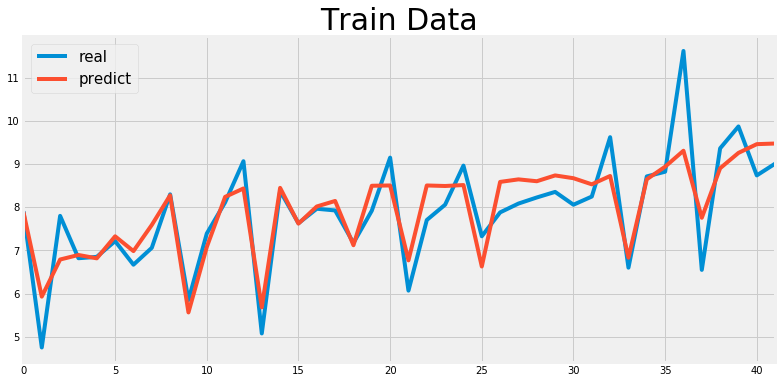

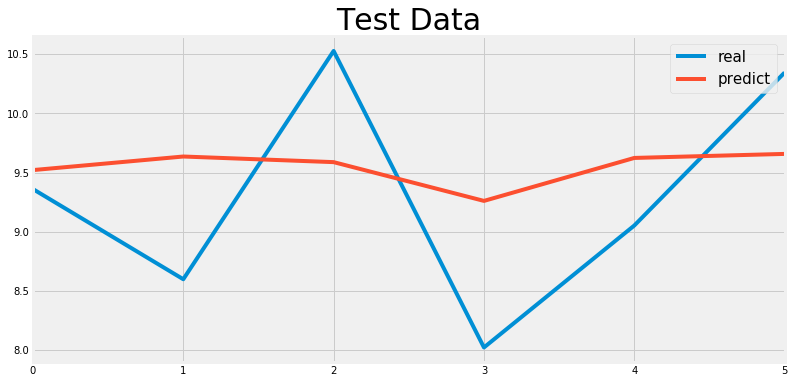

训练集上的MAE/MSE/MAPE/涨跌准确率
0.47529537910136355
0.40730308903360135
6.031087267282677
0.8292682926829268
测试集上的MAE/MSE/MAPE/涨跌准确率
0.7719695774371346
0.7187413641445883
8.107555091449093
0.6


In [15]:
output()

In [31]:
#带attention的lstm
from keras.layers import *
from keras.models import *
from keras.optimizers import Adam
#建立LSTM模型 训练
lstm_units=12
inputs=Input(shape=(window, amount_of_features))
model=LSTM(lstm_units,activation='relu',return_sequences=False)(inputs)#LSTM层
attention=Dense(lstm_units, activation='sigmoid', name='attention_vec')(model)#求解Attention权重
model=Multiply()([model, attention])#attention与LSTM对应数值相乘
outputs = Dense(1, activation='relu')(model)
model = Model(inputs=inputs, outputs=outputs)
model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
model.summary()#展示模型结构

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 12, 1)        0                                            
__________________________________________________________________________________________________
lstm_7 (LSTM)                   (None, 12)           672         input_5[0][0]                    
__________________________________________________________________________________________________
attention_vec (Dense)           (None, 12)           156         lstm_7[0][0]                     
__________________________________________________________________________________________________
multiply_5 (Multiply)           (None, 12)           0           lstm_7[0][0]                     
                                                                 attention_vec[0][0]        

In [32]:
#神经网络训练及结果
model.fit(X_train, y_train, nb_epoch =1000, batch_size = 32) #训练模型nb_epoch次

E:\anoconda\lib\site-packages\ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Epoch 1/1000
42/42 [==============================] - 0s 11ms/step - loss: 58.8408 - accuracy: 0.0000e+00
Epoch 2/1000
42/42 [==============================] - 0s 261us/step - loss: 58.1994 - accuracy: 0.0000e+00
Epoch 3/1000
42/42 [==============================] - 0s 285us/step - loss: 57.5223 - accuracy: 0.0000e+00
Epoch 4/1000
42/42 [==============================] - 0s 238us/step - loss: 56.8171 - accuracy: 0.0000e+00
Epoch 5/1000
42/42 [==============================] - 0s 238us/step - loss: 56.0911 - accuracy: 0.0000e+00
Epoch 6/1000
42/42 [==============================] - 0s 261us/step - loss: 55.3107 - accuracy: 0.0000e+00
Epoch 7/1000
42/42 [==============================] - 0s 237us/step - loss: 54.5154 - accuracy: 0.0000e+00
Epoch 8/1000
42/42 [==============================] - 0s 214us/step - loss: 53.6804 - accuracy: 0.0000e+00
Epoch 9/1000
42/42 [==============================] - 0s 237us/step - loss: 52.7786 - accuracy: 0.0000e+00
Epoch 10/1000
42/42 [=================

Epoch 77/1000
42/42 [==============================] - 0s 237us/step - loss: 1.2921 - accuracy: 0.0000e+00
Epoch 78/1000
42/42 [==============================] - 0s 261us/step - loss: 1.2980 - accuracy: 0.0000e+00
Epoch 79/1000
42/42 [==============================] - 0s 237us/step - loss: 1.2952 - accuracy: 0.0000e+00
Epoch 80/1000
42/42 [==============================] - 0s 214us/step - loss: 1.2865 - accuracy: 0.0000e+00
Epoch 81/1000
42/42 [==============================] - 0s 356us/step - loss: 1.2847 - accuracy: 0.0000e+00
Epoch 82/1000
42/42 [==============================] - 0s 309us/step - loss: 1.2836 - accuracy: 0.0000e+00
Epoch 83/1000
42/42 [==============================] - 0s 214us/step - loss: 1.2874 - accuracy: 0.0000e+00
Epoch 84/1000
42/42 [==============================] - 0s 261us/step - loss: 1.2997 - accuracy: 0.0000e+00
Epoch 85/1000
42/42 [==============================] - 0s 285us/step - loss: 1.3147 - accuracy: 0.0000e+00
Epoch 86/1000
42/42 [================

42/42 [==============================] - 0s 237us/step - loss: 1.2207 - accuracy: 0.0000e+00
Epoch 154/1000
42/42 [==============================] - 0s 214us/step - loss: 1.2113 - accuracy: 0.0000e+00
Epoch 155/1000
42/42 [==============================] - 0s 237us/step - loss: 1.2138 - accuracy: 0.0000e+00
Epoch 156/1000
42/42 [==============================] - 0s 237us/step - loss: 1.2084 - accuracy: 0.0000e+00
Epoch 157/1000
42/42 [==============================] - 0s 237us/step - loss: 1.2093 - accuracy: 0.0000e+00
Epoch 158/1000
42/42 [==============================] - 0s 594us/step - loss: 1.2205 - accuracy: 0.0000e+00
Epoch 159/1000
42/42 [==============================] - 0s 332us/step - loss: 1.2146 - accuracy: 0.0000e+00
Epoch 160/1000
42/42 [==============================] - 0s 237us/step - loss: 1.2053 - accuracy: 0.0000e+00
Epoch 161/1000
42/42 [==============================] - 0s 261us/step - loss: 1.1991 - accuracy: 0.0000e+00
Epoch 162/1000
42/42 [=====================

Epoch 229/1000
42/42 [==============================] - 0s 237us/step - loss: 1.1591 - accuracy: 0.0000e+00
Epoch 230/1000
42/42 [==============================] - 0s 237us/step - loss: 1.1614 - accuracy: 0.0000e+00
Epoch 231/1000
42/42 [==============================] - 0s 309us/step - loss: 1.1411 - accuracy: 0.0000e+00
Epoch 232/1000
42/42 [==============================] - 0s 285us/step - loss: 1.1358 - accuracy: 0.0000e+00
Epoch 233/1000
42/42 [==============================] - 0s 285us/step - loss: 1.1525 - accuracy: 0.0000e+00
Epoch 234/1000
42/42 [==============================] - 0s 285us/step - loss: 1.1672 - accuracy: 0.0000e+00
Epoch 235/1000
42/42 [==============================] - 0s 261us/step - loss: 1.1603 - accuracy: 0.0000e+00
Epoch 236/1000
42/42 [==============================] - 0s 285us/step - loss: 1.1547 - accuracy: 0.0000e+00
Epoch 237/1000
42/42 [==============================] - 0s 237us/step - loss: 1.1310 - accuracy: 0.0000e+00
Epoch 238/1000
42/42 [======

42/42 [==============================] - 0s 261us/step - loss: 0.9515 - accuracy: 0.0000e+00
Epoch 305/1000
42/42 [==============================] - 0s 285us/step - loss: 0.9712 - accuracy: 0.0000e+00
Epoch 306/1000
42/42 [==============================] - 0s 285us/step - loss: 0.9388 - accuracy: 0.0000e+00
Epoch 307/1000
42/42 [==============================] - 0s 261us/step - loss: 0.9467 - accuracy: 0.0000e+00
Epoch 308/1000
42/42 [==============================] - 0s 261us/step - loss: 0.9908 - accuracy: 0.0000e+00
Epoch 309/1000
42/42 [==============================] - 0s 237us/step - loss: 0.9856 - accuracy: 0.0000e+00
Epoch 310/1000
42/42 [==============================] - 0s 214us/step - loss: 0.9489 - accuracy: 0.0000e+00
Epoch 311/1000
42/42 [==============================] - 0s 261us/step - loss: 0.9229 - accuracy: 0.0000e+00
Epoch 312/1000
42/42 [==============================] - 0s 237us/step - loss: 0.9293 - accuracy: 0.0000e+00
Epoch 313/1000
42/42 [=====================

42/42 [==============================] - 0s 309us/step - loss: 0.7994 - accuracy: 0.0000e+00
Epoch 380/1000
42/42 [==============================] - 0s 309us/step - loss: 0.8375 - accuracy: 0.0000e+00
Epoch 381/1000
42/42 [==============================] - 0s 309us/step - loss: 0.7529 - accuracy: 0.0000e+00
Epoch 382/1000
42/42 [==============================] - 0s 261us/step - loss: 0.7546 - accuracy: 0.0000e+00
Epoch 383/1000
42/42 [==============================] - 0s 309us/step - loss: 0.7345 - accuracy: 0.0000e+00
Epoch 384/1000
42/42 [==============================] - 0s 332us/step - loss: 0.7721 - accuracy: 0.0000e+00
Epoch 385/1000
42/42 [==============================] - 0s 332us/step - loss: 0.7671 - accuracy: 0.0000e+00
Epoch 386/1000
42/42 [==============================] - 0s 261us/step - loss: 0.7412 - accuracy: 0.0000e+00
Epoch 387/1000
42/42 [==============================] - 0s 309us/step - loss: 0.7327 - accuracy: 0.0000e+00
Epoch 388/1000
42/42 [=====================

Epoch 455/1000
42/42 [==============================] - 0s 237us/step - loss: 0.5499 - accuracy: 0.0000e+00
Epoch 456/1000
42/42 [==============================] - 0s 261us/step - loss: 0.5269 - accuracy: 0.0000e+00
Epoch 457/1000
42/42 [==============================] - 0s 214us/step - loss: 0.5318 - accuracy: 0.0000e+00
Epoch 458/1000
42/42 [==============================] - 0s 237us/step - loss: 0.5330 - accuracy: 0.0000e+00
Epoch 459/1000
42/42 [==============================] - 0s 237us/step - loss: 0.5179 - accuracy: 0.0000e+00
Epoch 460/1000
42/42 [==============================] - 0s 332us/step - loss: 0.5351 - accuracy: 0.0000e+00
Epoch 461/1000
42/42 [==============================] - 0s 380us/step - loss: 0.5006 - accuracy: 0.0000e+00
Epoch 462/1000
42/42 [==============================] - 0s 332us/step - loss: 0.5857 - accuracy: 0.0000e+00
Epoch 463/1000
42/42 [==============================] - 0s 309us/step - loss: 0.5083 - accuracy: 0.0000e+00
Epoch 464/1000
42/42 [======

42/42 [==============================] - 0s 237us/step - loss: 0.3877 - accuracy: 0.0000e+00
Epoch 531/1000
42/42 [==============================] - 0s 190us/step - loss: 0.3847 - accuracy: 0.0000e+00
Epoch 532/1000
42/42 [==============================] - 0s 214us/step - loss: 0.3819 - accuracy: 0.0000e+00
Epoch 533/1000
42/42 [==============================] - 0s 237us/step - loss: 0.3816 - accuracy: 0.0000e+00
Epoch 534/1000
42/42 [==============================] - 0s 261us/step - loss: 0.3853 - accuracy: 0.0000e+00
Epoch 535/1000
42/42 [==============================] - 0s 237us/step - loss: 0.3753 - accuracy: 0.0000e+00
Epoch 536/1000
42/42 [==============================] - 0s 237us/step - loss: 0.4225 - accuracy: 0.0000e+00
Epoch 537/1000
42/42 [==============================] - 0s 214us/step - loss: 0.3763 - accuracy: 0.0000e+00
Epoch 538/1000
42/42 [==============================] - 0s 237us/step - loss: 0.4677 - accuracy: 0.0000e+00
Epoch 539/1000
42/42 [=====================

42/42 [==============================] - 0s 285us/step - loss: 0.3366 - accuracy: 0.0000e+00
Epoch 606/1000
42/42 [==============================] - 0s 238us/step - loss: 0.3635 - accuracy: 0.0000e+00
Epoch 607/1000
42/42 [==============================] - 0s 214us/step - loss: 0.3535 - accuracy: 0.0000e+00
Epoch 608/1000
42/42 [==============================] - 0s 237us/step - loss: 0.3287 - accuracy: 0.0000e+00
Epoch 609/1000
42/42 [==============================] - 0s 261us/step - loss: 0.3824 - accuracy: 0.0000e+00
Epoch 610/1000
42/42 [==============================] - 0s 237us/step - loss: 0.4213 - accuracy: 0.0000e+00
Epoch 611/1000
42/42 [==============================] - 0s 261us/step - loss: 0.3367 - accuracy: 0.0000e+00
Epoch 612/1000
42/42 [==============================] - 0s 237us/step - loss: 0.4798 - accuracy: 0.0000e+00
Epoch 613/1000
42/42 [==============================] - 0s 332us/step - loss: 0.3611 - accuracy: 0.0000e+00
Epoch 614/1000
42/42 [=====================

Epoch 681/1000
42/42 [==============================] - 0s 261us/step - loss: 0.3814 - accuracy: 0.0000e+00
Epoch 682/1000
42/42 [==============================] - 0s 261us/step - loss: 0.4356 - accuracy: 0.0000e+00
Epoch 683/1000
42/42 [==============================] - 0s 237us/step - loss: 0.2949 - accuracy: 0.0000e+00
Epoch 684/1000
42/42 [==============================] - 0s 237us/step - loss: 0.5359 - accuracy: 0.0000e+00
Epoch 685/1000
42/42 [==============================] - 0s 237us/step - loss: 0.3334 - accuracy: 0.0000e+00
Epoch 686/1000
42/42 [==============================] - 0s 237us/step - loss: 0.3837 - accuracy: 0.0000e+00
Epoch 687/1000
42/42 [==============================] - 0s 261us/step - loss: 0.3700 - accuracy: 0.0000e+00
Epoch 688/1000
42/42 [==============================] - 0s 214us/step - loss: 0.3535 - accuracy: 0.0000e+00
Epoch 689/1000
42/42 [==============================] - 0s 237us/step - loss: 0.3873 - accuracy: 0.0000e+00
Epoch 690/1000
42/42 [======

42/42 [==============================] - 0s 237us/step - loss: 0.3058 - accuracy: 0.0000e+00
Epoch 757/1000
42/42 [==============================] - 0s 214us/step - loss: 0.2953 - accuracy: 0.0000e+00
Epoch 758/1000
42/42 [==============================] - 0s 261us/step - loss: 0.3133 - accuracy: 0.0000e+00
Epoch 759/1000
42/42 [==============================] - 0s 214us/step - loss: 0.3113 - accuracy: 0.0000e+00
Epoch 760/1000
42/42 [==============================] - 0s 261us/step - loss: 0.3063 - accuracy: 0.0000e+00
Epoch 761/1000
42/42 [==============================] - 0s 285us/step - loss: 0.3000 - accuracy: 0.0000e+00
Epoch 762/1000
42/42 [==============================] - 0s 261us/step - loss: 0.2939 - accuracy: 0.0000e+00
Epoch 763/1000
42/42 [==============================] - 0s 356us/step - loss: 0.2919 - accuracy: 0.0000e+00
Epoch 764/1000
42/42 [==============================] - 0s 309us/step - loss: 0.2993 - accuracy: 0.0000e+00
Epoch 765/1000
42/42 [=====================

Epoch 832/1000
42/42 [==============================] - 0s 214us/step - loss: 0.2935 - accuracy: 0.0000e+00
Epoch 833/1000
42/42 [==============================] - 0s 214us/step - loss: 0.2755 - accuracy: 0.0000e+00
Epoch 834/1000
42/42 [==============================] - 0s 214us/step - loss: 0.2903 - accuracy: 0.0000e+00
Epoch 835/1000
42/42 [==============================] - 0s 214us/step - loss: 0.3151 - accuracy: 0.0000e+00
Epoch 836/1000
42/42 [==============================] - 0s 261us/step - loss: 0.2781 - accuracy: 0.0000e+00
Epoch 837/1000
42/42 [==============================] - 0s 214us/step - loss: 0.2986 - accuracy: 0.0000e+00
Epoch 838/1000
42/42 [==============================] - 0s 214us/step - loss: 0.2741 - accuracy: 0.0000e+00
Epoch 839/1000
42/42 [==============================] - 0s 190us/step - loss: 0.3230 - accuracy: 0.0000e+00
Epoch 840/1000
42/42 [==============================] - 0s 285us/step - loss: 0.2921 - accuracy: 0.0000e+00
Epoch 841/1000
42/42 [======

42/42 [==============================] - 0s 261us/step - loss: 0.2749 - accuracy: 0.0000e+00
Epoch 908/1000
42/42 [==============================] - 0s 261us/step - loss: 0.2653 - accuracy: 0.0000e+00
Epoch 909/1000
42/42 [==============================] - 0s 261us/step - loss: 0.2773 - accuracy: 0.0000e+00
Epoch 910/1000
42/42 [==============================] - 0s 261us/step - loss: 0.2820 - accuracy: 0.0000e+00
Epoch 911/1000
42/42 [==============================] - 0s 237us/step - loss: 0.2734 - accuracy: 0.0000e+00
Epoch 912/1000
42/42 [==============================] - 0s 237us/step - loss: 0.2682 - accuracy: 0.0000e+00
Epoch 913/1000
42/42 [==============================] - 0s 261us/step - loss: 0.2755 - accuracy: 0.0000e+00
Epoch 914/1000
42/42 [==============================] - 0s 285us/step - loss: 0.2836 - accuracy: 0.0000e+00
Epoch 915/1000
42/42 [==============================] - 0s 261us/step - loss: 0.2667 - accuracy: 0.0000e+00
Epoch 916/1000
42/42 [=====================

Epoch 983/1000
42/42 [==============================] - 0s 261us/step - loss: 0.2936 - accuracy: 0.0000e+00
Epoch 984/1000
42/42 [==============================] - 0s 261us/step - loss: 0.2608 - accuracy: 0.0000e+00
Epoch 985/1000
42/42 [==============================] - 0s 237us/step - loss: 0.2495 - accuracy: 0.0000e+00
Epoch 986/1000
42/42 [==============================] - 0s 261us/step - loss: 0.2550 - accuracy: 0.0000e+00
Epoch 987/1000
42/42 [==============================] - 0s 237us/step - loss: 0.2831 - accuracy: 0.0000e+00
Epoch 988/1000
42/42 [==============================] - 0s 214us/step - loss: 0.2940 - accuracy: 0.0000e+00
Epoch 989/1000
42/42 [==============================] - 0s 237us/step - loss: 0.2469 - accuracy: 0.0000e+00
Epoch 990/1000
42/42 [==============================] - 0s 237us/step - loss: 0.2929 - accuracy: 0.0000e+00
Epoch 991/1000
42/42 [==============================] - 0s 261us/step - loss: 0.2584 - accuracy: 0.0000e+00
Epoch 992/1000
42/42 [======

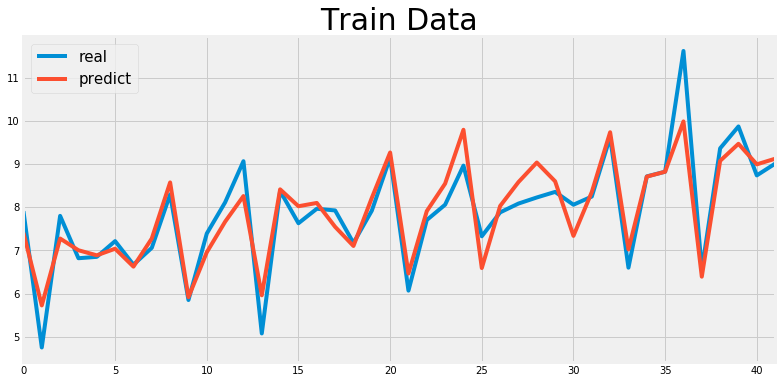

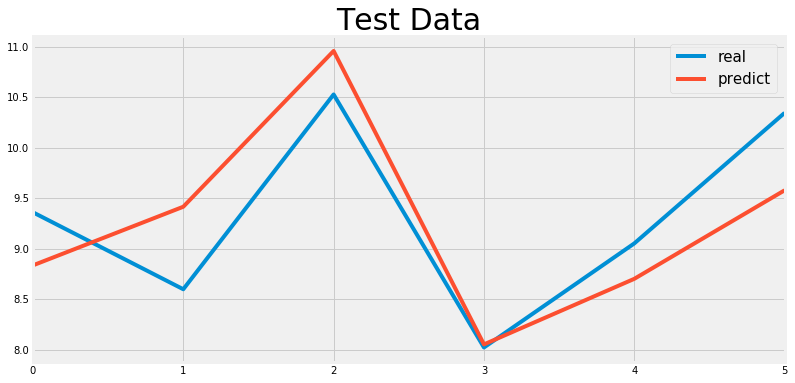

训练集上的MAE/MSE/MAPE/涨跌准确率
0.3702904901931424
0.24465114848863578
4.787705456897918
0.9512195121951219
测试集上的MAE/MSE/MAPE/涨跌准确率
0.48661752725114277
0.3065333211618246
5.158489963570513
0.8


In [33]:
output()